In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm as tqdm

%matplotlib inline

import torch
import torchvision

import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random

from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print(device)

cpu


In [2]:
np.random.seed(1)

y = np.concatenate((np.zeros(500),np.ones(500),np.ones(500)*2,np.ones(500)*3,np.ones(500)*4,
                    np.ones(500)*5,np.ones(500)*6,np.ones(500)*7,np.ones(500)*8,np.ones(500)*9))
#y = np.random.randint(0,3,6000)
idx= []
for i in range(10):
    print(i,sum(y==i))
    idx.append(y==i)

0 500
1 500
2 500
3 500
4 500
5 500
6 500
7 500
8 500
9 500


In [3]:
x = np.zeros((5000,2))


np.random.seed(12)
x[idx[0],:] = np.random.multivariate_normal(mean = [4,6.5],cov=[[0.01,0],[0,0.01]],size=sum(idx[0]))
x[idx[1],:] = np.random.multivariate_normal(mean = [5.5,6],cov=[[0.01,0],[0,0.01]],size=sum(idx[1]))
x[idx[2],:] = np.random.multivariate_normal(mean = [4.5,4.5],cov=[[0.01,0],[0,0.01]],size=sum(idx[2]))
x[idx[3],:] = np.random.multivariate_normal(mean = [3,3.5],cov=[[0.01,0],[0,0.01]],size=sum(idx[3]))
x[idx[4],:] = np.random.multivariate_normal(mean = [2.5,5.5],cov=[[0.01,0],[0,0.01]],size=sum(idx[4]))
x[idx[5],:] = np.random.multivariate_normal(mean = [3.5,8],cov=[[0.01,0],[0,0.01]],size=sum(idx[5]))
x[idx[6],:] = np.random.multivariate_normal(mean = [5.5,8],cov=[[0.01,0],[0,0.01]],size=sum(idx[6]))
x[idx[7],:] = np.random.multivariate_normal(mean = [7,6.5],cov=[[0.01,0],[0,0.01]],size=sum(idx[7]))
x[idx[8],:] = np.random.multivariate_normal(mean = [6.5,4.5],cov=[[0.01,0],[0,0.01]],size=sum(idx[8]))
x[idx[9],:] = np.random.multivariate_normal(mean = [5,3],cov=[[0.01,0],[0,0.01]],size=sum(idx[9]))

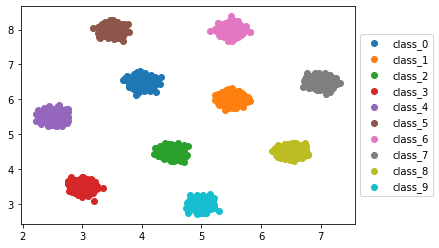

In [4]:
for i in range(10):
    plt.scatter(x[idx[i],0],x[idx[i],1],label="class_"+str(i))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [5]:
mean_x = np.mean(x,axis=0,keepdims=True)
std_x = np.std(x,axis=0,keepdims=True) 
x = ( x - mean_x  )  / std_x

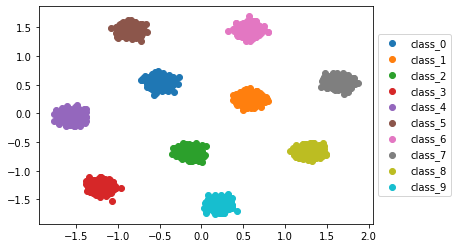

In [6]:
for i in range(10):
    plt.scatter(x[idx[i],0],x[idx[i],1],label="class_"+str(i))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [7]:
foreground_classes = {'class_0','class_1' }

background_classes = {'bg_classes',}

In [8]:
desired_num = 3000  # 2000 + 1000


m = 500



mosaic_list_of_images =[]
mosaic_label = []
fore_idx=[]
for j in tqdm(range(desired_num)):
    np.random.seed(j)
    fg_class  = np.random.randint(0,3)
    fg_idx = 0#np.random.randint(0,m)
    a = []
    for i in range(m):
        if i == fg_idx:
            b = np.random.choice(np.where(idx[fg_class]==True)[0],size=1)
            a.append(x[b])
#             print("foreground "+str(fg_class)+" present at " + str(fg_idx))
        else:
            bg_class = np.random.randint(3,10)
            b = np.random.choice(np.where(idx[bg_class]==True)[0],size=1)
            a.append(x[b])
#             print("background "+str(bg_class)+" present at " + str(i))
    a = np.concatenate(a,axis=0)
    mosaic_list_of_images.append(np.reshape(a,(m,2)))
    mosaic_label.append(fg_class)
    fore_idx.append(fg_idx)

100%|███████████████████████████████████████| 3000/3000 [00:37<00:00, 79.52it/s]


In [9]:
def create_sin_data(mosaic_dataset,labels,fg_n,m):
  """
  mosaic_dataset : mosaic_dataset contains 500 patches of dimendion 2 each as 1 data point
  labels : mosaic_dataset labels
  foreground_index : contains list of indexes where foreground image is present so that using this we can take weighted average
  """
  n_points = len(mosaic_dataset)
  patches = mosaic_dataset[0].shape[0]
  dims = mosaic_dataset[0].shape[1]
  img = np.zeros((n_points,patches,dims))

  for i in tqdm(range(len(mosaic_dataset))):
    for j in range(m):
      if j < fg_n:
        img[i][j] = mosaic_dataset[i][0]
      else:
        #print(j)
        index = np.random.randint(1,500,1)
        img[i][j]= mosaic_dataset[i][index]
    
    
  return  img,labels

In [10]:
avg_image_dataset_1 , labels_1 = create_sin_data(mosaic_list_of_images[0:2000], mosaic_label[0:2000],1,500)
avg_image_dataset_2 , labels_2 = create_sin_data(mosaic_list_of_images[0:2000], mosaic_label[0:2000],12,500)
avg_image_dataset_3 , labels_3 = create_sin_data(mosaic_list_of_images[0:2000], mosaic_label[0:2000],25,500)
avg_image_dataset_4, labels_4 = create_sin_data(mosaic_list_of_images[0:2000], mosaic_label[0:2000],50,500)
avg_image_dataset_5 , labels_5 = create_sin_data(mosaic_list_of_images[0:2000], mosaic_label[0:2000],100,500)
avg_image_dataset_6 , labels_6 = create_sin_data(mosaic_list_of_images[0:2000], mosaic_label[0:2000],150,500)
avg_image_dataset_7 , labels_7 = create_sin_data(mosaic_list_of_images[0:2000], mosaic_label[0:2000],200,500)
avg_image_dataset_8 , labels_8 = create_sin_data(mosaic_list_of_images[0:2000], mosaic_label[0:2000],250,500)
avg_image_dataset_9 , labels_9 = create_sin_data(mosaic_list_of_images[0:2000], mosaic_label[0:2000],300,500)
avg_image_dataset_10 , labels_10 = create_sin_data(mosaic_list_of_images[0:2000], mosaic_label[0:2000],350,500)
avg_image_dataset_11 , labels_11 = create_sin_data(mosaic_list_of_images[0:2000], mosaic_label[0:2000],400,500)
avg_image_dataset_12 , labels_12 = create_sin_data(mosaic_list_of_images[0:2000], mosaic_label[0:2000],450,500)
avg_image_dataset_13 , labels_13 = create_sin_data(mosaic_list_of_images[0:2000], mosaic_label[0:2000],500,500)
avg_image_dataset_14, labels_14 = create_sin_data(mosaic_list_of_images[2000:], mosaic_label[2000:],500,500)


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 2578.29it/s]


In [11]:
avg_image_dataset_1 = np.stack(avg_image_dataset_1)
avg_image_dataset_2 = np.stack(avg_image_dataset_2,axis=0)
avg_image_dataset_3 = np.stack(avg_image_dataset_3,axis=0)
avg_image_dataset_4 = np.stack(avg_image_dataset_4,axis=0)
avg_image_dataset_5 = np.stack(avg_image_dataset_5,axis=0)
avg_image_dataset_6 = np.stack(avg_image_dataset_6,axis=0)
avg_image_dataset_7 = np.stack(avg_image_dataset_7,axis=0)
avg_image_dataset_8 = np.stack(avg_image_dataset_8,axis=0)
avg_image_dataset_9 = np.stack(avg_image_dataset_9,axis=0)
avg_image_dataset_10 = np.stack(avg_image_dataset_10,axis=0)
avg_image_dataset_11 = np.stack(avg_image_dataset_11,axis=0)
avg_image_dataset_12 = np.stack(avg_image_dataset_12,axis=0)
avg_image_dataset_13 = np.stack(avg_image_dataset_13,axis=0)
avg_image_dataset_14 = np.stack(avg_image_dataset_14,axis=0)

In [12]:
avg_image_dataset_1.shape

(2000, 500, 2)

Text(0.5, 1.0, 'Test Dataset')

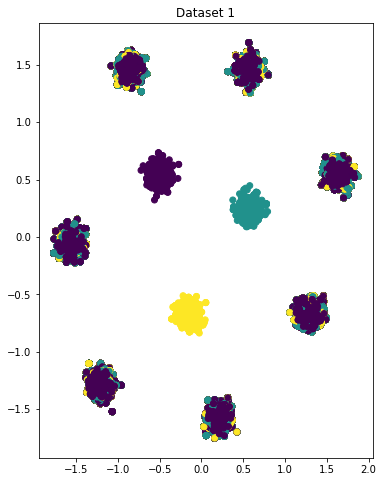

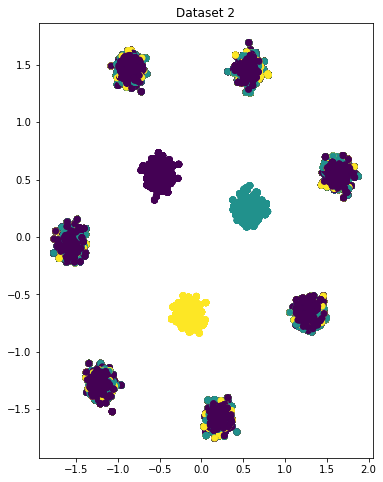

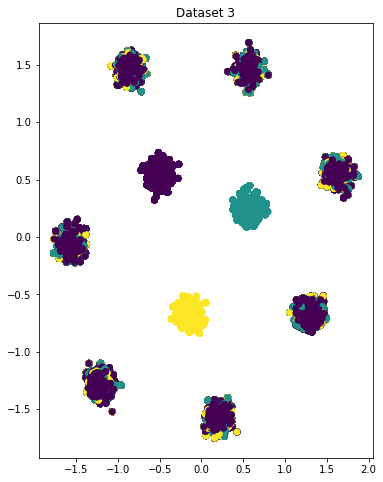

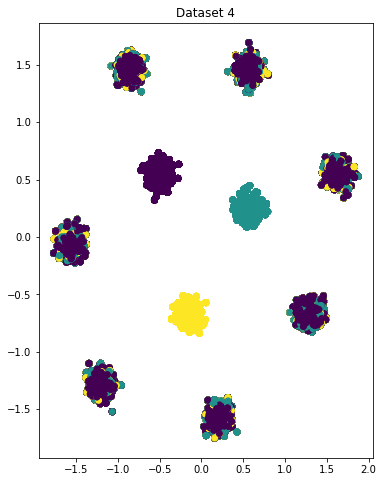

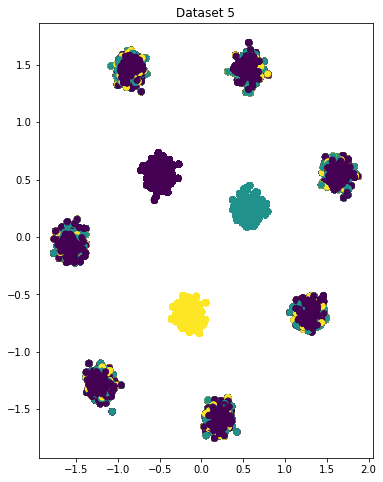

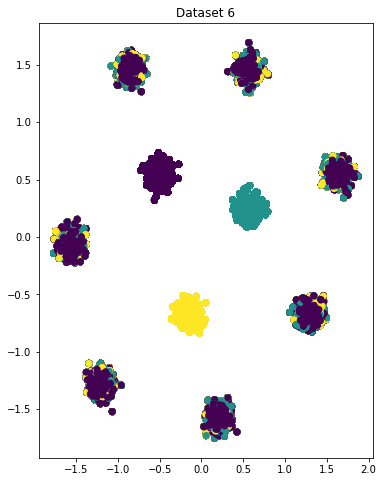

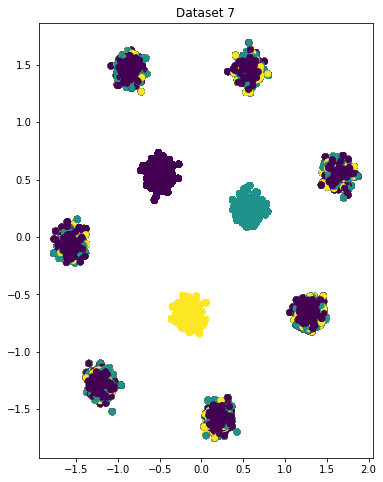

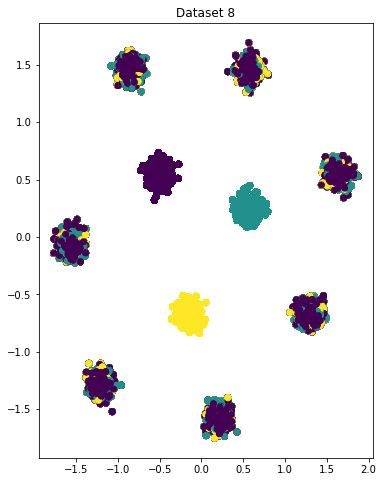

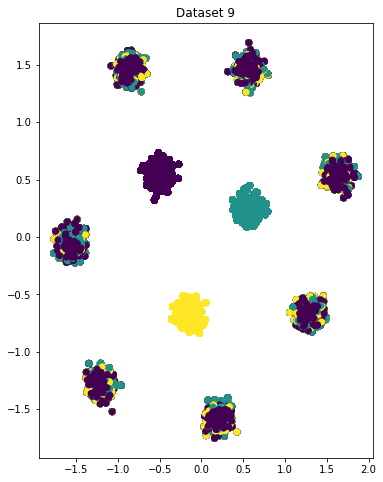

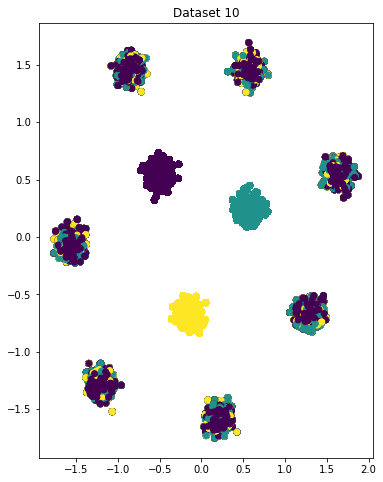

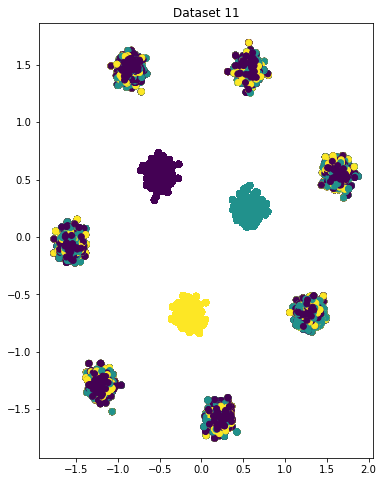

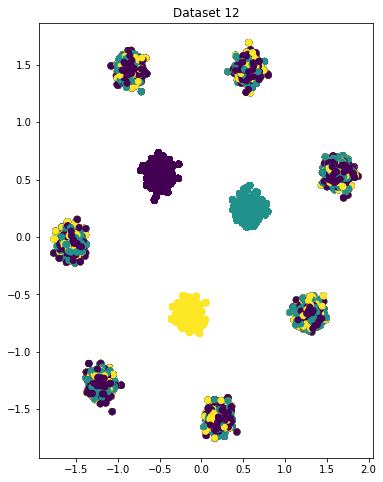

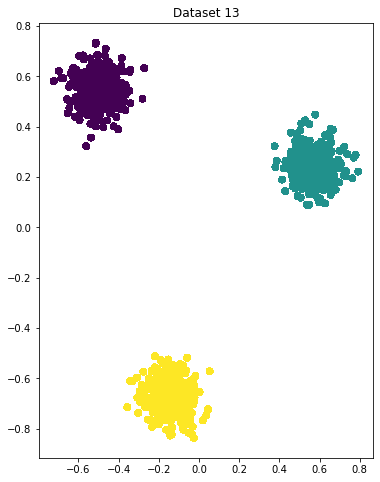

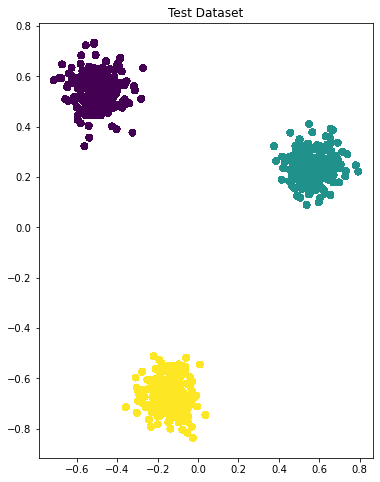

In [13]:
plt.figure(figsize=(6,8))
temp1 = np.reshape(avg_image_dataset_1,(2000*500,2))
temp_labels = torch.tensor(labels_1).repeat_interleave(500).numpy()
plt.scatter(temp1[:,0],temp1[:,1],c=temp_labels)
plt.title("Dataset 1")


plt.figure(figsize=(6,8))
temp1 = np.reshape(avg_image_dataset_2,(2000*500,2))
temp_labels = torch.tensor(labels_2).repeat_interleave(500).numpy()
plt.scatter(temp1[:,0],temp1[:,1],c=temp_labels)
plt.title("Dataset 2")



plt.figure(figsize=(6,8))
temp1 = np.reshape(avg_image_dataset_3,(2000*500,2))
temp_labels = torch.tensor(labels_3).repeat_interleave(500).numpy()
plt.scatter(temp1[:,0],temp1[:,1],c=temp_labels)
plt.title("Dataset 3")

plt.figure(figsize=(6,8))
temp1 = np.reshape(avg_image_dataset_4,(2000*500,2))
temp_labels = torch.tensor(labels_4).repeat_interleave(500).numpy()
plt.scatter(temp1[:,0],temp1[:,1],c=temp_labels)
plt.title("Dataset 4")

plt.figure(figsize=(6,8))
temp1 = np.reshape(avg_image_dataset_5,(2000*500,2))
temp_labels = torch.tensor(labels_5).repeat_interleave(500).numpy()
plt.scatter(temp1[:,0],temp1[:,1],c=temp_labels)
plt.title("Dataset 5")

plt.figure(figsize=(6,8))
temp1 = np.reshape(avg_image_dataset_6,(2000*500,2))
temp_labels = torch.tensor(labels_6).repeat_interleave(500).numpy()
plt.scatter(temp1[:,0],temp1[:,1],c=temp_labels)
plt.title("Dataset 6")

plt.figure(figsize=(6,8))
temp1 = np.reshape(avg_image_dataset_7,(2000*500,2))
temp_labels = torch.tensor(labels_7).repeat_interleave(500).numpy()
plt.scatter(temp1[:,0],temp1[:,1],c=temp_labels)
plt.title("Dataset 7")

plt.figure(figsize=(6,8))
temp1 = np.reshape(avg_image_dataset_8,(2000*500,2))
temp_labels = torch.tensor(labels_8).repeat_interleave(500).numpy()
plt.scatter(temp1[:,0],temp1[:,1],c=temp_labels)
plt.title("Dataset 8")

plt.figure(figsize=(6,8))
temp1 = np.reshape(avg_image_dataset_9,(2000*500,2))
temp_labels = torch.tensor(labels_9).repeat_interleave(500).numpy()
plt.scatter(temp1[:,0],temp1[:,1],c=temp_labels)
plt.title("Dataset 9")

plt.figure(figsize=(6,8))
temp1 = np.reshape(avg_image_dataset_10,(2000*500,2))
temp_labels = torch.tensor(labels_10).repeat_interleave(500).numpy()
plt.scatter(temp1[:,0],temp1[:,1],c=temp_labels)
plt.title("Dataset 10")


plt.figure(figsize=(6,8))
temp1 = np.reshape(avg_image_dataset_11,(2000*500,2))
temp_labels = torch.tensor(labels_11).repeat_interleave(500).numpy()
plt.scatter(temp1[:,0],temp1[:,1],c=temp_labels)
plt.title("Dataset 11")

plt.figure(figsize=(6,8))
temp1 = np.reshape(avg_image_dataset_12,(2000*500,2))
temp_labels = torch.tensor(labels_12).repeat_interleave(500).numpy()
plt.scatter(temp1[:,0],temp1[:,1],c=temp_labels)
plt.title("Dataset 12")

plt.figure(figsize=(6,8))
temp1 = np.reshape(avg_image_dataset_13,(2000*500,2))
temp_labels = torch.tensor(labels_13).repeat_interleave(500).numpy()
plt.scatter(temp1[:,0],temp1[:,1],c=temp_labels)
plt.title("Dataset 13")

plt.figure(figsize=(6,8))
temp1 = np.reshape(avg_image_dataset_14,(1000*500,2))
temp_labels = torch.tensor(labels_14).repeat_interleave(500).numpy()
plt.scatter(temp1[:,0],temp1[:,1],c=temp_labels)
plt.title("Test Dataset")

In [14]:
class MosaicDataset(Dataset):
  """MosaicDataset dataset."""

  def __init__(self, mosaic_list_of_images, mosaic_label):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.mosaic = mosaic_list_of_images
    self.label = mosaic_label
    #self.fore_idx = fore_idx
    
  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    return self.mosaic[idx] , self.label[idx] #, self.fore_idx[idx]

In [15]:
batch = 256


# training_data = avg_image_dataset_5    #just change this and training_label to desired dataset for training
# training_label = labels_5

traindata_1 = MosaicDataset(avg_image_dataset_1, labels_1 )
trainloader_1 = DataLoader( traindata_1 , batch_size= batch ,shuffle=True)

traindata_2 = MosaicDataset(avg_image_dataset_2, labels_2 )
trainloader_2 = DataLoader( traindata_2 , batch_size= batch ,shuffle=True)

traindata_3 = MosaicDataset(avg_image_dataset_3, labels_3 )
trainloader_3 = DataLoader( traindata_3 , batch_size= batch ,shuffle=True)

traindata_4 = MosaicDataset(avg_image_dataset_4, labels_4 )
trainloader_4 = DataLoader( traindata_4 , batch_size= batch ,shuffle=True)

traindata_5 = MosaicDataset(avg_image_dataset_5, labels_5 )
trainloader_5 = DataLoader( traindata_5 , batch_size= batch ,shuffle=True)

traindata_6 = MosaicDataset(avg_image_dataset_6, labels_6 )
trainloader_6 = DataLoader( traindata_6 , batch_size= batch ,shuffle=True)

traindata_7 = MosaicDataset(avg_image_dataset_7, labels_7 )
trainloader_7 = DataLoader( traindata_7 , batch_size= batch ,shuffle=True)

traindata_8 = MosaicDataset(avg_image_dataset_8, labels_8 )
trainloader_8 = DataLoader( traindata_8 , batch_size= batch ,shuffle=True)

traindata_9 = MosaicDataset(avg_image_dataset_9, labels_9 )
trainloader_9 = DataLoader( traindata_9 , batch_size= batch ,shuffle=True)


traindata_10 = MosaicDataset(avg_image_dataset_10, labels_10 )
trainloader_10 = DataLoader( traindata_10 , batch_size= batch ,shuffle=True)

traindata_11 = MosaicDataset(avg_image_dataset_11, labels_11)
trainloader_11 = DataLoader( traindata_11 , batch_size= batch ,shuffle=True)

traindata_12 = MosaicDataset(avg_image_dataset_12, labels_12)
trainloader_12 = DataLoader( traindata_12 , batch_size= batch ,shuffle=True)

traindata_13 = MosaicDataset(avg_image_dataset_13, labels_13)
trainloader_13 = DataLoader( traindata_13 , batch_size= batch ,shuffle=True)




testdata_1 = MosaicDataset(avg_image_dataset_1, labels_1 )
testloader_1 = DataLoader( testdata_1 , batch_size= batch ,shuffle=False)

testdata_2 = MosaicDataset(avg_image_dataset_2, labels_2 )
testloader_2 = DataLoader( testdata_2 , batch_size= batch ,shuffle=False)

testdata_3 = MosaicDataset(avg_image_dataset_3, labels_3 )
testloader_3 = DataLoader( testdata_3 , batch_size= batch ,shuffle=False)

testdata_4 = MosaicDataset(avg_image_dataset_4, labels_4 )
testloader_4 = DataLoader( testdata_4 , batch_size= batch ,shuffle=False)

testdata_5 = MosaicDataset(avg_image_dataset_5, labels_5 )
testloader_5 = DataLoader( testdata_5 , batch_size= batch ,shuffle=False)

testdata_6 = MosaicDataset(avg_image_dataset_6, labels_6 )
testloader_6 = DataLoader( testdata_6 , batch_size= batch ,shuffle=False)

testdata_7 = MosaicDataset(avg_image_dataset_7, labels_7 )
testloader_7 = DataLoader( testdata_7 , batch_size= batch ,shuffle=False)

testdata_8 = MosaicDataset(avg_image_dataset_8, labels_8 )
testloader_8 = DataLoader( testdata_8 , batch_size= batch ,shuffle=False)

testdata_9 = MosaicDataset(avg_image_dataset_9, labels_9 )
testloader_9 = DataLoader( testdata_9 , batch_size= batch ,shuffle=False)

testdata_10 = MosaicDataset(avg_image_dataset_10, labels_10 )
testloader_10 = DataLoader( testdata_10 , batch_size= batch ,shuffle=False)

testdata_11 = MosaicDataset(avg_image_dataset_11, labels_11 )
testloader_11 = DataLoader( testdata_11 , batch_size= batch ,shuffle=False)


testdata_12 = MosaicDataset(avg_image_dataset_12, labels_12 )
testloader_12 = DataLoader( testdata_12, batch_size= batch ,shuffle=False)


testdata_13 = MosaicDataset(avg_image_dataset_13, labels_13)
testloader_13 = DataLoader( testdata_13 , batch_size= batch ,shuffle=False)


testdata_14 = MosaicDataset(avg_image_dataset_14, labels_14 )
testloader_14 = DataLoader( testdata_14 , batch_size= batch ,shuffle=False)





In [16]:
data,labels = iter(trainloader_1).next()

In [17]:
data.shape,labels.shape

(torch.Size([256, 500, 2]), torch.Size([256]))

In [18]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(2, 3)
    torch.nn.init.xavier_normal_(self.fc1.weight)
    torch.nn.init.zeros_(self.fc1.bias)
  def forward(self, x):
    x = self.fc1(x)
    # print(x.shape)
    return x

In [19]:
def my_cross_entropy(output,target,loss_criterion):
    
    
    batch = output.size(0)
    #print(batch)
    patches = output.size(1)
    classes = output.size(2)
    output = torch.reshape(output,(batch*patches,classes))    
    target = target.repeat_interleave(patches)
    
    loss = loss_criterion(output,target)
    #print(final_loss)
    return loss

In [20]:
def test_all(number, testloader,net):
    correct = 0
    total = 0
    # out = []
    # pred = []
    net.eval()
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device),labels.to(device)
            # out.append(labels.cpu().numpy())
            outputs= net(images)

            batch = outputs.size(0)
            #print(batch)
            patches = outputs.size(1)
            classes = outputs.size(2)
            outputs = torch.reshape(outputs,(batch*patches,classes)) 

            _, predicted = torch.max(outputs.data, 1)
            # pred.append(predicted.cpu().numpy())
            labels = labels.repeat_interleave(patches)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the test dataset %d: %d %%' % (number , 100 * correct / total))

In [21]:
def train_all(trainloader, ds_number, testloader_list):
    
    print("--"*40)
    print("training on data set  ", ds_number)
    torch.manual_seed(12)
    net = Net().double()
    net = net.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.01)#, momentum=0.9)
    
    acti = []
    loss_curi = []
    epochs = 300
    
    for epoch in range(epochs): # loop over the dataset multiple times
        ep_lossi = []

        running_loss = 0.0
        if epoch ==0:
            with torch.no_grad():
                for k, data in enumerate(trainloader, 0):
                    inputs, labels = data
                    inputs, labels = inputs.to(device),labels.to(device)
                    outputs = net(inputs)
                    loss = my_cross_entropy(outputs, labels,criterion)
                    running_loss += loss.item()
                    if k+1 ==8:
                        print(k+1)
                        ep_lossi.append(running_loss/(k+1))
                        print('[%d, %5d] loss: %.3f' %(epoch, k+ 1, running_loss/(k+1) ))
                        running_loss = 0.0  
                loss_curi.append(np.mean(ep_lossi))
                ep_lossi = [] 
                    
                    
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data
            inputs, labels = inputs.to(device),labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = my_cross_entropy(outputs, labels,criterion)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            mini = 8
            if i % mini == (mini-1):    
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / ( mini ) ))
                ep_lossi.append(running_loss/ (mini) ) # loss per minibatch
                running_loss = 0.0
                
        loss_curi.append(np.mean(ep_lossi))   #loss per epoch
    print('Finished Training')
    torch.save(net.state_dict(),"train_dataset_"+str(ds_number)+"_"+str(epochs)+".pt")
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in trainloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)

            batch = outputs.size(0)
            #print(batch)
            patches = outputs.size(1)
            classes = outputs.size(2)
            outputs = torch.reshape(outputs,(batch*patches,classes)) 
            
            _, predicted = torch.max(outputs.data, 1)
            labels = labels.repeat_interleave(patches)
            #print(predicted.shape,labels.shape,patches)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the train images: %d %%' % (  100 * correct / total))
    
    for i, j in enumerate(testloader_list):
        test_all(i+1, j,net)
    
    print("--"*40)
    
    return loss_curi


In [22]:
train_loss_all=[]

testloader_list= [ testloader_1, testloader_2, testloader_3, testloader_4, testloader_5, testloader_6,
                 testloader_7, testloader_8, testloader_9, testloader_10,testloader_11,testloader_12,testloader_13,testloader_14]

train_loss_all.append(train_all(trainloader_1, 1, testloader_list))
train_loss_all.append(train_all(trainloader_2, 2, testloader_list))
train_loss_all.append(train_all(trainloader_3, 3, testloader_list))
train_loss_all.append(train_all(trainloader_4, 4, testloader_list))
train_loss_all.append(train_all(trainloader_5, 5, testloader_list))
train_loss_all.append(train_all(trainloader_6, 6, testloader_list))
train_loss_all.append(train_all(trainloader_7, 7, testloader_list))
train_loss_all.append(train_all(trainloader_8, 8, testloader_list))
train_loss_all.append(train_all(trainloader_9, 9, testloader_list))
train_loss_all.append(train_all(trainloader_10, 10, testloader_list))
train_loss_all.append(train_all(trainloader_11, 11, testloader_list))
train_loss_all.append(train_all(trainloader_12, 12, testloader_list))
train_loss_all.append(train_all(trainloader_13, 13, testloader_list))

--------------------------------------------------------------------------------
training on data set   1
8
[0,     8] loss: 1.199
[1,     8] loss: 1.183
[2,     8] loss: 1.152
[3,     8] loss: 1.130
[4,     8] loss: 1.115
[5,     8] loss: 1.106
[6,     8] loss: 1.101
[7,     8] loss: 1.099
[8,     8] loss: 1.099
[9,     8] loss: 1.099
[10,     8] loss: 1.099
[11,     8] loss: 1.099
[12,     8] loss: 1.099
[13,     8] loss: 1.099
[14,     8] loss: 1.099
[15,     8] loss: 1.099
[16,     8] loss: 1.099
[17,     8] loss: 1.099
[18,     8] loss: 1.099
[19,     8] loss: 1.099
[20,     8] loss: 1.099
[21,     8] loss: 1.099
[22,     8] loss: 1.099
[23,     8] loss: 1.099
[24,     8] loss: 1.099
[25,     8] loss: 1.099
[26,     8] loss: 1.099
[27,     8] loss: 1.099
[28,     8] loss: 1.099
[29,     8] loss: 1.099
[30,     8] loss: 1.099
[31,     8] loss: 1.099
[32,     8] loss: 1.099
[33,     8] loss: 1.099
[34,     8] loss: 1.099
[35,     8] loss: 1.099
[36,     8] loss: 1.099
[37,     8] lo

8
[0,     8] loss: 1.196
[1,     8] loss: 1.180
[2,     8] loss: 1.150
[3,     8] loss: 1.128
[4,     8] loss: 1.114
[5,     8] loss: 1.105
[6,     8] loss: 1.100
[7,     8] loss: 1.099
[8,     8] loss: 1.099
[9,     8] loss: 1.099
[10,     8] loss: 1.099
[11,     8] loss: 1.099
[12,     8] loss: 1.099
[13,     8] loss: 1.099
[14,     8] loss: 1.099
[15,     8] loss: 1.099
[16,     8] loss: 1.098
[17,     8] loss: 1.099
[18,     8] loss: 1.099
[19,     8] loss: 1.099
[20,     8] loss: 1.099
[21,     8] loss: 1.099
[22,     8] loss: 1.099
[23,     8] loss: 1.098
[24,     8] loss: 1.099
[25,     8] loss: 1.099
[26,     8] loss: 1.099
[27,     8] loss: 1.099
[28,     8] loss: 1.099
[29,     8] loss: 1.099
[30,     8] loss: 1.099
[31,     8] loss: 1.099
[32,     8] loss: 1.099
[33,     8] loss: 1.099
[34,     8] loss: 1.099
[35,     8] loss: 1.099
[36,     8] loss: 1.099
[37,     8] loss: 1.099
[38,     8] loss: 1.099
[39,     8] loss: 1.099
[40,     8] loss: 1.099
[41,     8] loss: 1.099


[1,     8] loss: 1.177
[2,     8] loss: 1.148
[3,     8] loss: 1.127
[4,     8] loss: 1.113
[5,     8] loss: 1.104
[6,     8] loss: 1.100
[7,     8] loss: 1.099
[8,     8] loss: 1.098
[9,     8] loss: 1.098
[10,     8] loss: 1.098
[11,     8] loss: 1.098
[12,     8] loss: 1.098
[13,     8] loss: 1.098
[14,     8] loss: 1.098
[15,     8] loss: 1.098
[16,     8] loss: 1.098
[17,     8] loss: 1.098
[18,     8] loss: 1.098
[19,     8] loss: 1.098
[20,     8] loss: 1.098
[21,     8] loss: 1.098
[22,     8] loss: 1.098
[23,     8] loss: 1.098
[24,     8] loss: 1.098
[25,     8] loss: 1.098
[26,     8] loss: 1.098
[27,     8] loss: 1.098
[28,     8] loss: 1.098
[29,     8] loss: 1.098
[30,     8] loss: 1.098
[31,     8] loss: 1.098
[32,     8] loss: 1.098
[33,     8] loss: 1.098
[34,     8] loss: 1.098
[35,     8] loss: 1.098
[36,     8] loss: 1.098
[37,     8] loss: 1.098
[38,     8] loss: 1.098
[39,     8] loss: 1.098
[40,     8] loss: 1.098
[41,     8] loss: 1.098
[42,     8] loss: 1.098
[

8
[0,     8] loss: 1.185
[1,     8] loss: 1.171
[2,     8] loss: 1.143
[3,     8] loss: 1.124
[4,     8] loss: 1.110
[5,     8] loss: 1.103
[6,     8] loss: 1.099
[7,     8] loss: 1.097
[8,     8] loss: 1.097
[9,     8] loss: 1.097
[10,     8] loss: 1.097
[11,     8] loss: 1.097
[12,     8] loss: 1.097
[13,     8] loss: 1.097
[14,     8] loss: 1.097
[15,     8] loss: 1.097
[16,     8] loss: 1.097
[17,     8] loss: 1.097
[18,     8] loss: 1.097
[19,     8] loss: 1.097
[20,     8] loss: 1.097
[21,     8] loss: 1.097
[22,     8] loss: 1.097
[23,     8] loss: 1.097
[24,     8] loss: 1.097
[25,     8] loss: 1.097
[26,     8] loss: 1.097
[27,     8] loss: 1.097
[28,     8] loss: 1.097
[29,     8] loss: 1.097
[30,     8] loss: 1.097
[31,     8] loss: 1.097
[32,     8] loss: 1.097
[33,     8] loss: 1.097
[34,     8] loss: 1.097
[35,     8] loss: 1.097
[36,     8] loss: 1.097
[37,     8] loss: 1.097
[38,     8] loss: 1.097
[39,     8] loss: 1.097
[40,     8] loss: 1.097
[41,     8] loss: 1.097


[1,     8] loss: 1.159
[2,     8] loss: 1.133
[3,     8] loss: 1.116
[4,     8] loss: 1.104
[5,     8] loss: 1.097
[6,     8] loss: 1.093
[7,     8] loss: 1.091
[8,     8] loss: 1.090
[9,     8] loss: 1.090
[10,     8] loss: 1.090
[11,     8] loss: 1.090
[12,     8] loss: 1.090
[13,     8] loss: 1.090
[14,     8] loss: 1.090
[15,     8] loss: 1.090
[16,     8] loss: 1.090
[17,     8] loss: 1.090
[18,     8] loss: 1.090
[19,     8] loss: 1.090
[20,     8] loss: 1.090
[21,     8] loss: 1.090
[22,     8] loss: 1.090
[23,     8] loss: 1.090
[24,     8] loss: 1.090
[25,     8] loss: 1.090
[26,     8] loss: 1.090
[27,     8] loss: 1.090
[28,     8] loss: 1.090
[29,     8] loss: 1.090
[30,     8] loss: 1.090
[31,     8] loss: 1.090
[32,     8] loss: 1.090
[33,     8] loss: 1.090
[34,     8] loss: 1.090
[35,     8] loss: 1.090
[36,     8] loss: 1.090
[37,     8] loss: 1.090
[38,     8] loss: 1.090
[39,     8] loss: 1.090
[40,     8] loss: 1.090
[41,     8] loss: 1.090
[42,     8] loss: 1.090
[

[1,     8] loss: 1.146
[2,     8] loss: 1.120
[3,     8] loss: 1.104
[4,     8] loss: 1.093
[5,     8] loss: 1.085
[6,     8] loss: 1.081
[7,     8] loss: 1.078
[8,     8] loss: 1.077
[9,     8] loss: 1.077
[10,     8] loss: 1.077
[11,     8] loss: 1.077
[12,     8] loss: 1.077
[13,     8] loss: 1.077
[14,     8] loss: 1.077
[15,     8] loss: 1.077
[16,     8] loss: 1.077
[17,     8] loss: 1.077
[18,     8] loss: 1.077
[19,     8] loss: 1.077
[20,     8] loss: 1.077
[21,     8] loss: 1.077
[22,     8] loss: 1.077
[23,     8] loss: 1.077
[24,     8] loss: 1.077
[25,     8] loss: 1.077
[26,     8] loss: 1.077
[27,     8] loss: 1.077
[28,     8] loss: 1.077
[29,     8] loss: 1.077
[30,     8] loss: 1.077
[31,     8] loss: 1.077
[32,     8] loss: 1.077
[33,     8] loss: 1.077
[34,     8] loss: 1.077
[35,     8] loss: 1.077
[36,     8] loss: 1.077
[37,     8] loss: 1.077
[38,     8] loss: 1.077
[39,     8] loss: 1.077
[40,     8] loss: 1.077
[41,     8] loss: 1.077
[42,     8] loss: 1.077
[

8
[0,     8] loss: 1.146
[1,     8] loss: 1.133
[2,     8] loss: 1.105
[3,     8] loss: 1.086
[4,     8] loss: 1.074
[5,     8] loss: 1.066
[6,     8] loss: 1.061
[7,     8] loss: 1.058
[8,     8] loss: 1.057
[9,     8] loss: 1.056
[10,     8] loss: 1.056
[11,     8] loss: 1.056
[12,     8] loss: 1.056
[13,     8] loss: 1.056
[14,     8] loss: 1.056
[15,     8] loss: 1.056
[16,     8] loss: 1.056
[17,     8] loss: 1.056
[18,     8] loss: 1.056
[19,     8] loss: 1.056
[20,     8] loss: 1.056
[21,     8] loss: 1.056
[22,     8] loss: 1.056
[23,     8] loss: 1.056
[24,     8] loss: 1.056
[25,     8] loss: 1.056
[26,     8] loss: 1.056
[27,     8] loss: 1.056
[28,     8] loss: 1.056
[29,     8] loss: 1.056
[30,     8] loss: 1.056
[31,     8] loss: 1.056
[32,     8] loss: 1.056
[33,     8] loss: 1.056
[34,     8] loss: 1.056
[35,     8] loss: 1.056
[36,     8] loss: 1.056
[37,     8] loss: 1.056
[38,     8] loss: 1.056
[39,     8] loss: 1.056
[40,     8] loss: 1.056
[41,     8] loss: 1.056


[1,     8] loss: 1.117
[2,     8] loss: 1.085
[3,     8] loss: 1.062
[4,     8] loss: 1.046
[5,     8] loss: 1.035
[6,     8] loss: 1.029
[7,     8] loss: 1.026
[8,     8] loss: 1.024
[9,     8] loss: 1.023
[10,     8] loss: 1.023
[11,     8] loss: 1.023
[12,     8] loss: 1.023
[13,     8] loss: 1.023
[14,     8] loss: 1.023
[15,     8] loss: 1.023
[16,     8] loss: 1.023
[17,     8] loss: 1.023
[18,     8] loss: 1.023
[19,     8] loss: 1.023
[20,     8] loss: 1.023
[21,     8] loss: 1.023
[22,     8] loss: 1.023
[23,     8] loss: 1.023
[24,     8] loss: 1.023
[25,     8] loss: 1.023
[26,     8] loss: 1.023
[27,     8] loss: 1.023
[28,     8] loss: 1.023
[29,     8] loss: 1.023
[30,     8] loss: 1.023
[31,     8] loss: 1.023
[32,     8] loss: 1.023
[33,     8] loss: 1.023
[34,     8] loss: 1.023
[35,     8] loss: 1.023
[36,     8] loss: 1.023
[37,     8] loss: 1.023
[38,     8] loss: 1.023
[39,     8] loss: 1.023
[40,     8] loss: 1.023
[41,     8] loss: 1.023
[42,     8] loss: 1.023
[

[1,     8] loss: 1.102
[2,     8] loss: 1.065
[3,     8] loss: 1.035
[4,     8] loss: 1.013
[5,     8] loss: 0.997
[6,     8] loss: 0.986
[7,     8] loss: 0.979
[8,     8] loss: 0.975
[9,     8] loss: 0.972
[10,     8] loss: 0.971
[11,     8] loss: 0.970
[12,     8] loss: 0.970
[13,     8] loss: 0.970
[14,     8] loss: 0.970
[15,     8] loss: 0.970
[16,     8] loss: 0.969
[17,     8] loss: 0.970
[18,     8] loss: 0.970
[19,     8] loss: 0.970
[20,     8] loss: 0.970
[21,     8] loss: 0.970
[22,     8] loss: 0.969
[23,     8] loss: 0.970
[24,     8] loss: 0.970
[25,     8] loss: 0.970
[26,     8] loss: 0.970
[27,     8] loss: 0.970
[28,     8] loss: 0.970
[29,     8] loss: 0.970
[30,     8] loss: 0.970
[31,     8] loss: 0.970
[32,     8] loss: 0.970
[33,     8] loss: 0.970
[34,     8] loss: 0.970
[35,     8] loss: 0.970
[36,     8] loss: 0.970
[37,     8] loss: 0.970
[38,     8] loss: 0.969
[39,     8] loss: 0.970
[40,     8] loss: 0.970
[41,     8] loss: 0.970
[42,     8] loss: 0.970
[

8
[0,     8] loss: 1.106
[1,     8] loss: 1.087
[2,     8] loss: 1.044
[3,     8] loss: 1.009
[4,     8] loss: 0.980
[5,     8] loss: 0.956
[6,     8] loss: 0.938
[7,     8] loss: 0.924
[8,     8] loss: 0.913
[9,     8] loss: 0.905
[10,     8] loss: 0.899
[11,     8] loss: 0.895
[12,     8] loss: 0.892
[13,     8] loss: 0.889
[14,     8] loss: 0.888
[15,     8] loss: 0.886
[16,     8] loss: 0.886
[17,     8] loss: 0.885
[18,     8] loss: 0.884
[19,     8] loss: 0.884
[20,     8] loss: 0.884
[21,     8] loss: 0.884
[22,     8] loss: 0.884
[23,     8] loss: 0.884
[24,     8] loss: 0.884
[25,     8] loss: 0.884
[26,     8] loss: 0.884
[27,     8] loss: 0.884
[28,     8] loss: 0.884
[29,     8] loss: 0.884
[30,     8] loss: 0.884
[31,     8] loss: 0.883
[32,     8] loss: 0.884
[33,     8] loss: 0.884
[34,     8] loss: 0.883
[35,     8] loss: 0.884
[36,     8] loss: 0.884
[37,     8] loss: 0.884
[38,     8] loss: 0.884
[39,     8] loss: 0.884
[40,     8] loss: 0.884
[41,     8] loss: 0.884


[1,     8] loss: 1.071
[2,     8] loss: 1.023
[3,     8] loss: 0.981
[4,     8] loss: 0.944
[5,     8] loss: 0.913
[6,     8] loss: 0.885
[7,     8] loss: 0.862
[8,     8] loss: 0.843
[9,     8] loss: 0.826
[10,     8] loss: 0.812
[11,     8] loss: 0.800
[12,     8] loss: 0.790
[13,     8] loss: 0.782
[14,     8] loss: 0.775
[15,     8] loss: 0.769
[16,     8] loss: 0.764
[17,     8] loss: 0.759
[18,     8] loss: 0.756
[19,     8] loss: 0.753
[20,     8] loss: 0.751
[21,     8] loss: 0.748
[22,     8] loss: 0.747
[23,     8] loss: 0.745
[24,     8] loss: 0.744
[25,     8] loss: 0.743
[26,     8] loss: 0.743
[27,     8] loss: 0.742
[28,     8] loss: 0.741
[29,     8] loss: 0.741
[30,     8] loss: 0.740
[31,     8] loss: 0.740
[32,     8] loss: 0.740
[33,     8] loss: 0.739
[34,     8] loss: 0.739
[35,     8] loss: 0.739
[36,     8] loss: 0.739
[37,     8] loss: 0.739
[38,     8] loss: 0.739
[39,     8] loss: 0.739
[40,     8] loss: 0.739
[41,     8] loss: 0.739
[42,     8] loss: 0.739
[

[1,     8] loss: 1.056
[2,     8] loss: 1.001
[3,     8] loss: 0.951
[4,     8] loss: 0.905
[5,     8] loss: 0.863
[6,     8] loss: 0.825
[7,     8] loss: 0.791
[8,     8] loss: 0.760
[9,     8] loss: 0.732
[10,     8] loss: 0.708
[11,     8] loss: 0.685
[12,     8] loss: 0.665
[13,     8] loss: 0.647
[14,     8] loss: 0.631
[15,     8] loss: 0.617
[16,     8] loss: 0.603
[17,     8] loss: 0.592
[18,     8] loss: 0.581
[19,     8] loss: 0.572
[20,     8] loss: 0.563
[21,     8] loss: 0.556
[22,     8] loss: 0.549
[23,     8] loss: 0.543
[24,     8] loss: 0.537
[25,     8] loss: 0.532
[26,     8] loss: 0.528
[27,     8] loss: 0.524
[28,     8] loss: 0.520
[29,     8] loss: 0.516
[30,     8] loss: 0.514
[31,     8] loss: 0.511
[32,     8] loss: 0.508
[33,     8] loss: 0.506
[34,     8] loss: 0.504
[35,     8] loss: 0.502
[36,     8] loss: 0.501
[37,     8] loss: 0.499
[38,     8] loss: 0.498
[39,     8] loss: 0.497
[40,     8] loss: 0.496
[41,     8] loss: 0.495
[42,     8] loss: 0.494
[

[1,     8] loss: 1.039
[2,     8] loss: 0.975
[3,     8] loss: 0.915
[4,     8] loss: 0.858
[5,     8] loss: 0.805
[6,     8] loss: 0.755
[7,     8] loss: 0.708
[8,     8] loss: 0.664
[9,     8] loss: 0.624
[10,     8] loss: 0.586
[11,     8] loss: 0.551
[12,     8] loss: 0.518
[13,     8] loss: 0.488
[14,     8] loss: 0.460
[15,     8] loss: 0.434
[16,     8] loss: 0.410
[17,     8] loss: 0.387
[18,     8] loss: 0.367
[19,     8] loss: 0.348
[20,     8] loss: 0.330
[21,     8] loss: 0.313
[22,     8] loss: 0.298
[23,     8] loss: 0.283
[24,     8] loss: 0.270
[25,     8] loss: 0.257
[26,     8] loss: 0.246
[27,     8] loss: 0.235
[28,     8] loss: 0.225
[29,     8] loss: 0.215
[30,     8] loss: 0.206
[31,     8] loss: 0.198
[32,     8] loss: 0.190
[33,     8] loss: 0.182
[34,     8] loss: 0.175
[35,     8] loss: 0.169
[36,     8] loss: 0.163
[37,     8] loss: 0.157
[38,     8] loss: 0.151
[39,     8] loss: 0.146
[40,     8] loss: 0.141
[41,     8] loss: 0.136
[42,     8] loss: 0.132
[

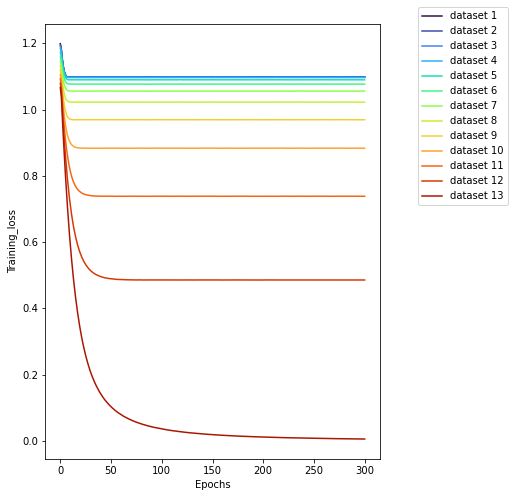

In [23]:
cm = plt.get_cmap('turbo')
fig = plt.figure(figsize=(6,8))
for i,j in enumerate(train_loss_all):
   plt.plot(j,label ="dataset "+str(i+1),color = cm(i*20))
plt.xlabel("Epochs")
plt.ylabel("Training_loss")

plt.legend(bbox_to_anchor=(1.1, 1.05))